In [3]:
import pandas as pd
import numpy as np

# Data

In [4]:
df = pd.read_csv('HR_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [5]:
df['target'].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [6]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [7]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

# Preprocessing

skema preprocessing

* x = semua kolom, kecuali target dan enrollee_id
* y = target


* city,major_discipline,company_type,education_level,experience,company_size,last_new_job = binary
* gender,relevent_experience,enrolled_university = oneHot
* city_development_index,training_hours = scaling



* imputer = value constant

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

In [9]:
df['training_hours']

0         36
1         47
2         83
3         52
4          8
        ... 
19153     42
19154     52
19155     44
19156     97
19157    127
Name: training_hours, Length: 19158, dtype: int64

In [10]:
pipe_binary= Pipeline([
    ('impute',SimpleImputer(strategy='constant',fill_value='P')),
    ('binary',ce.BinaryEncoder())
])

pipe_onehot= Pipeline([
  ('impute_mode', SimpleImputer(strategy='constant',fill_value='P')),
  ('one hot', OneHotEncoder()) 
])

scaler = RobustScaler()

transformer = ColumnTransformer([
    ('Binary',pipe_binary,['city','major_discipline','company_type','education_level','experience','company_size','last_new_job']),
    ('One Hot', pipe_onehot,['gender','relevent_experience','enrolled_university']),
    ('Scaling', scaler,['city_development_index','training_hours'])
], remainder='passthrough')

# Model Selection

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
import seaborn as sns

In [13]:
from sklearn.model_selection import cross_val_score


In [14]:
logreg = LogisticRegression(random_state=2020)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=2020)
rf = RandomForestClassifier()

In [15]:
x = df.drop(columns=['enrollee_id','target'])
y = df['target']

In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=.2,random_state=2020)

In [17]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [18]:
models = [logreg,knn,dt,rf]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
    ('preprocess',transformer),
    ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1')#
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

In [19]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],'mean':rata,'sdev':std}).set_index('model').sort_values(by='mean',ascending=False)

,mean,sdev
model,,
Random Forest,0.505476,0.006052
KNN,0.491552,0.008829
Decision Tree,0.447833,0.006025
Logistic Regression,0.425666,0.011016


Random Forest memiliki nilai mean cross-validation yang lebih tinggi dan lebih stabil karena memiliki standar deviasi yang cukup rendah

# Hyperparameter Tuning

In [20]:
# estimator.get_params()

In [21]:
hyperparam_space={
    'model__n_estimators':[300],
    'model__max_features':['auto','sqrt'],
    'model__max_depth':[None,2,4],
    'model__min_samples_split':[5,7,9,11],
    'model__min_samples_leaf':[2,3,4],
    'model__bootstrap':[True,False],
    'model__class_weight':[None,'balanced', 'balanced_subsample'],
    'model__criterion':['gini','entropy']
    
}

In [22]:
skfold=StratifiedKFold(n_splits=5)
grid_search=GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)

In [23]:
grid_search.fit(x_train,y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.6355609946439895
{'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'auto', 'model__min_samples_leaf': 4, 'model__min_samples_split': 9, 'model__n_estimators': 300}


In [24]:
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',rf)])

estimator.fit(x_train,y_train)
y_pred=estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85      2877
         1.0       0.55      0.41      0.47       955

    accuracy                           0.77      3832
   macro avg       0.68      0.65      0.66      3832
weighted avg       0.75      0.77      0.76      3832



In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

## Resampling

In [26]:
nearmiss=NearMiss()
smote = SMOTE()
model= RandomForestClassifier()
estimator= Pipeline([
    ('preprocess', transformer),
    ('resampling', smote),
    ('model',model)
])

In [27]:
skfold= StratifiedKFold(n_splits=5)
model_cv=cross_val_score(estimator, x_train, y_train, cv=skfold, scoring='f1')
print('cv score', model_cv)
print('cv score mean', model_cv.mean())

cv score [0.61269656 0.62740525 0.630296   0.63231036 0.64617169]
cv score mean 0.6297759730948622


## Threshold optimization

In [28]:
from sklearn.metrics import f1_score

In [29]:
x_train2, x_val, y_train2, y_val= train_test_split(x_train,y_train, stratify=y_train, test_size=.25, random_state= 2020)

In [30]:
estimator.fit(x_train2,y_train2)

th_value= [i/100 for i in range(20,60)]
score=0
score_list=[]

for i in th_value:
    y_prob= estimator.predict_proba(x_val)[:,1]
    y_pred=np.where(y_prob>i,1,0)
    score_temp= f1_score(y_val,y_pred)
    score_list.append(score_temp)
    
    if score_temp>score:
        score=score_temp
        
        best_score=score
        best_th=i

<AxesSubplot:>

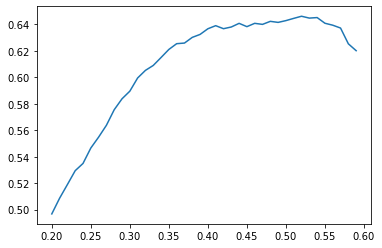

In [31]:
sns.lineplot(th_value,score_list)

In [32]:
print('best score', best_score)
print('best th', best_th)

best score 0.6462264150943396
best th 0.52


## Kesimpulan

In [33]:
#sebelum tuning

estimator=Pipeline([
    ('preprocess',transformer),
    ('model',rf)])

estimator.fit(x_train,y_train)
y_pred=estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      2877
         1.0       0.57      0.45      0.50       955

    accuracy                           0.78      3832
   macro avg       0.70      0.67      0.68      3832
weighted avg       0.76      0.78      0.77      3832



In [38]:
model = RandomForestClassifier(bootstrap=True,class_weight='balanced',criterion='entropy',
                                    max_depth=None,max_features='auto',min_samples_leaf=4,min_samples_split=9,
                                   n_estimators=300)

In [39]:
#Setelah tuning

estimator=Pipeline([
    ('preprocess',transformer),
    ('model',model)])

estimator.fit(x_train,y_train)
y_pred=estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85      2877
         1.0       0.56      0.71      0.62       955

    accuracy                           0.79      3832
   macro avg       0.73      0.76      0.74      3832
weighted avg       0.81      0.79      0.79      3832



In [42]:
#Resampling
estimator= Pipeline([
    ('preprocess', transformer),
    ('resampling', smote),
    ('model',model)
])

estimator.fit(x_train,y_train)
y_pred=estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      2877
         1.0       0.57      0.64      0.60       955

    accuracy                           0.79      3832
   macro avg       0.72      0.74      0.73      3832
weighted avg       0.80      0.79      0.79      3832



In [57]:
#Treshhold

estimator=Pipeline([
    ('preprocess',transformer),
    ('model',model)])

estimator.fit(x_train,y_train)
y_prob=estimator.predict_proba(x_test)[:,1]
y_pred=np.where(y_prob>0.52,1,0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85      2877
         1.0       0.56      0.70      0.62       955

    accuracy                           0.79      3832
   macro avg       0.72      0.76      0.74      3832
weighted avg       0.81      0.79      0.79      3832

